# Search for Runaways



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import os
os.getcwd()

'/home/kevin_leo_mcmanus/repos/runawaysearch'

## Load up Stars, Cluster Info

In [3]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [4]:
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3

In [5]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

## Collect GAIA Sample Data

In [7]:
cluster_names = ['Pleiades', 'alphaPer']
search_results = {}

from gaiastars import from_pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')


In [8]:
#exclude the known members returned from the search
for cl in cluster_names:
    merged_fs = search_results[cl].merge(cluster_members[cl])
    print(f'------ {cl} -------')
    print(merged_fs.objs.which.value_counts())
    fs = merged_fs.query('which == \'{} cone search\''.format(cl))
    fs.name = 'Search Results, Known Members excluded'
    search_results[cl] = fs

------ Pleiades -------
Pleiades cone search    107919
both                      1225
Pleiades                   101
Name: which, dtype: int64
------ alphaPer -------
alphaPer cone search    291664
both                       699
alphaPer                    41
Name: which, dtype: int64


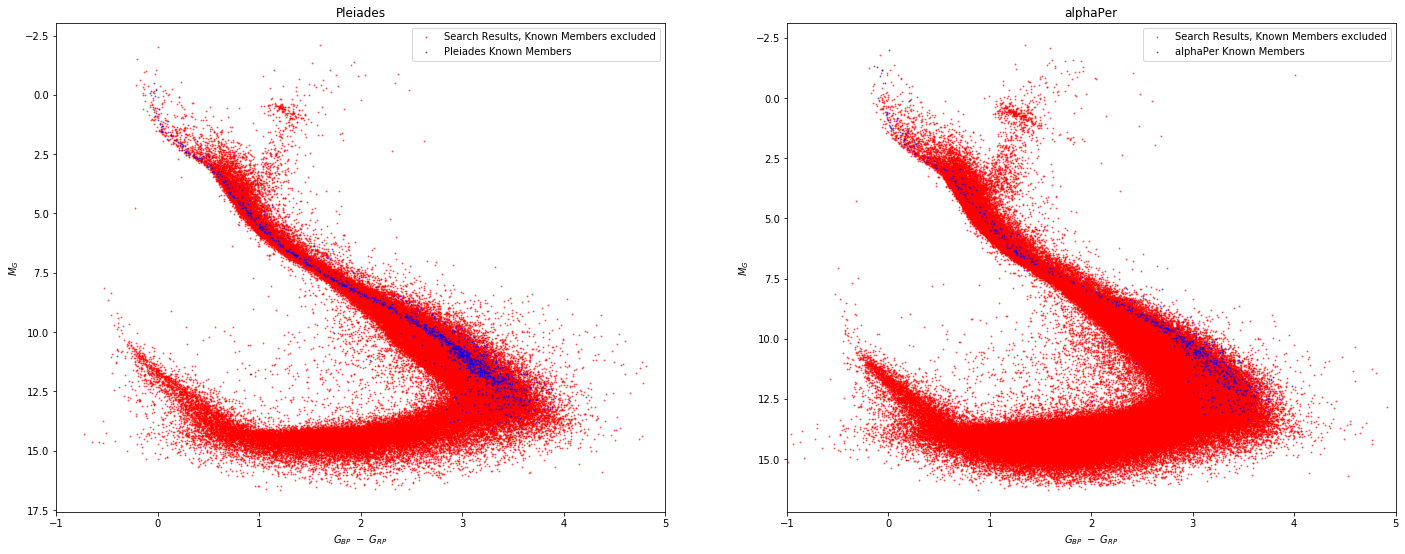

In [9]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='red', alpha=0.5, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()


## Evaluate `travel_time` Relationship

In [10]:
for cl in cluster_names:
    search_results[cl].travel_time(cluster_info.loc[cl]['coords'], inplace=True)

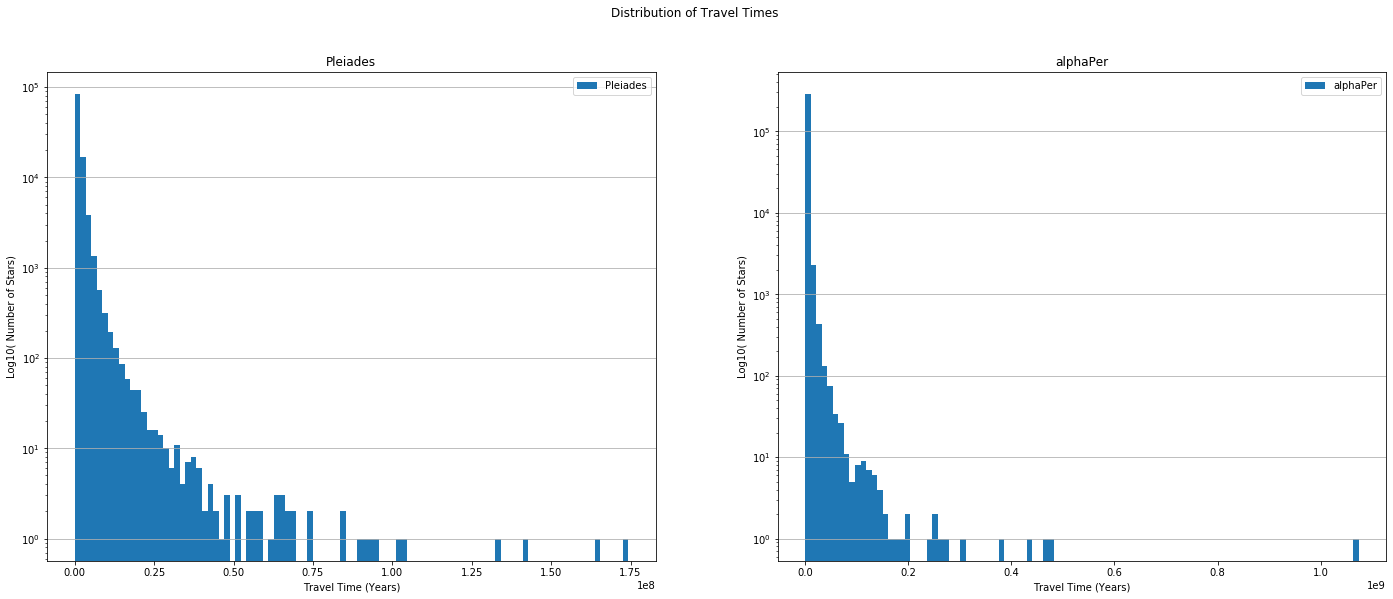

In [11]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    ax[i].hist(search_results[cl].objs.travel_time, bins=100, log=True, label=cl)
    ax[i].set_title(cl)
    ax[i].set_xlabel('Travel Time (Years)')
    ax[i].set_ylabel('Log10( Number of Stars)')
    ax[i].legend()
    ax[i].grid(axis='y')
zz = fig.suptitle('Distribution of Travel Times')

In [12]:
search_results['Pleiades'].objs.query('travel_time > 0.7e8')

,_merge,which,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,...,cen_pm_ra_cosdec,cen_pm_dec,pm_ra_cosdec_censr,pm_dec_censr,proj_pmra,proj_pmdec,mag_ppm,mag_ppm_r,mag_ppm_pc,travel_time
source_id,,,,,,,,,,,,,,,,,,,,,
10014905957383296,left_only,Pleiades cone search,51.812971,7.454613,4.942604,20.591808,-45.339827,NaN,16.090483,17.396332,...,19.997,-45.548,0.594808,0.208173,1.057070,0.369957,1.119940,5.429621e-09,1.098535e-06,8.486628e+07
173567501108177792,left_only,Pleiades cone search,71.522201,34.060047,6.743920,19.492669,-45.400105,NaN,13.641747,14.530089,...,19.997,-45.548,-0.504331,0.147895,-0.566478,0.166119,0.590333,2.862016e-09,4.243846e-07,8.412575e+07
179032829812844800,left_only,Pleiades cone search,66.142360,37.569654,10.509597,19.854351,-46.174794,NaN,16.410416,18.708393,...,19.997,-45.548,-0.142649,-0.626794,-0.183390,-0.805808,0.826413,4.006563e-09,3.812290e-07,1.417916e+08
184443663974115200,left_only,Pleiades cone search,80.565695,37.044812,8.760846,20.258433,-46.219824,NaN,9.364925,9.621474,...,19.997,-45.548,0.261433,-0.671824,0.279796,-0.719010,0.771532,3.740492e-09,4.269555e-07,1.016212e+08
200406408145543424,left_only,Pleiades cone search,73.078009,41.585516,6.724149,20.194652,-44.757650,NaN,16.515057,18.016209,...,19.997,-45.548,0.197652,0.790350,0.216494,0.865694,0.892354,4.326253e-09,6.433904e-07,9.057684e+07
203218580933424384,left_only,Pleiades cone search,70.426073,41.570972,8.196759,20.199987,-45.039645,16.749063,8.771386,8.984380,...,19.997,-45.548,0.202987,0.508355,0.203301,0.509140,0.548229,2.657889e-09,3.242610e-07,1.642113e+08
222330085886009088,left_only,Pleiades cone search,52.041402,36.449513,7.143785,19.388703,-45.446830,NaN,15.051531,16.362720,...,19.997,-45.548,-0.608297,0.101170,-0.627585,0.104378,0.636206,3.084412e-09,4.317616e-07,9.276023e+07
224736298365647488,left_only,Pleiades cone search,56.343835,39.820849,8.566144,18.948115,-46.040260,10.100863,11.460646,11.948377,...,19.997,-45.548,-1.048885,-0.492260,-1.071694,-0.502965,1.183850,5.739468e-09,6.700176e-07,7.378334e+07
236548450565345152,left_only,Pleiades cone search,53.513563,39.672641,8.164867,20.755290,-45.718855,NaN,19.399813,21.621317,...,19.997,-45.548,0.758290,-0.170855,0.761713,-0.171627,0.780809,3.785468e-09,4.636288e-07,1.039402e+08


## Evaluate `points_to` Relationship

In [13]:
cluster_info.loc[cl]['coords']

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (52.06, 49.06, 174.88632389)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (22.929, -25.556, -0.29)>

In [14]:
for cl in cluster_names:
    maxsep = cluster_members[cl].maxsep() /2.0
    print(f'{cl}: Maxsep: {maxsep}')
    search_results[cl].points_to(cluster_info.loc[cl]['coords'],maxsep.value, inplace=True, allcalcs=False)



Pleiades: Maxsep: 3.328984626197819 deg
alphaPer: Maxsep: 2.5454915501451394 deg


In [15]:
search_results['Pleiades'].objs.columns

Index(['_merge', 'which', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'radial_velocity', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ruwe', 'r_est', 'theta', 'cen_dist', 'beta',
       'cen_pm_ra_cosdec', 'cen_pm_dec', 'pm_ra_cosdec_censr', 'pm_dec_censr',
       'proj_pmra', 'proj_pmdec', 'mag_ppm', 'mag_ppm_r', 'mag_ppm_pc',
       'travel_time', 'points_to'],
      dtype='object')

In [16]:
search_results['Pleiades'].objs.points_to.sum()

11485

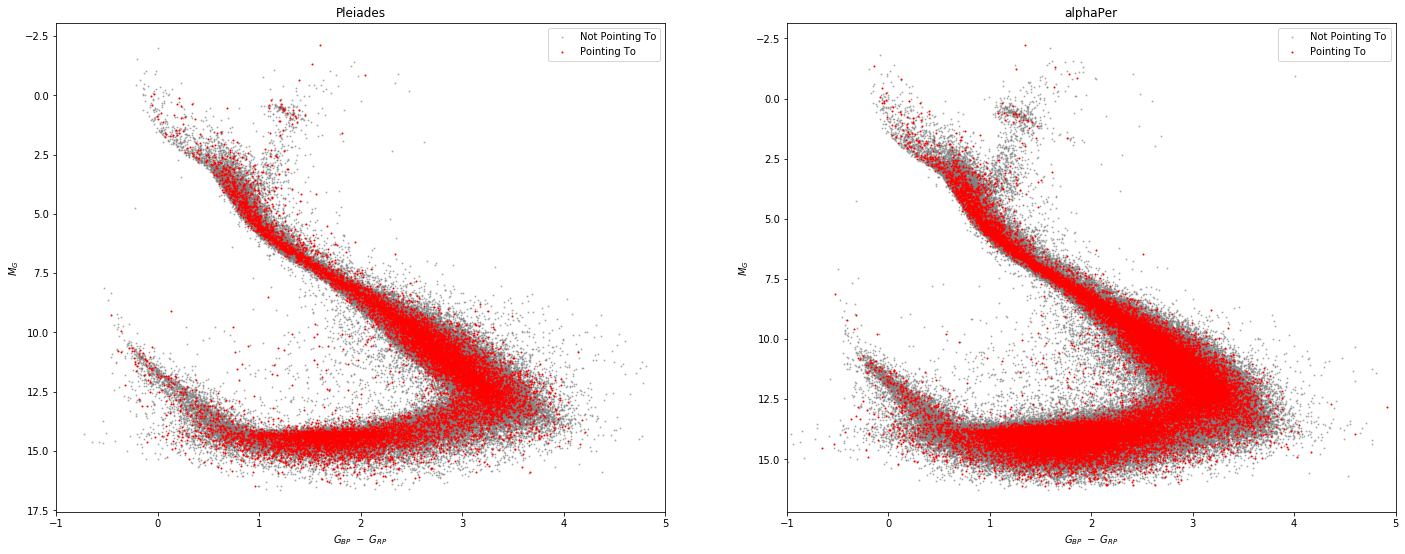

In [17]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('~points_to').plot_hrdiagram(ax=ax[i], color='grey', alpha=0.5, s=1, label="Not Pointing To")
    search_results[cl].query('points_to').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=1, label='Pointing To')
    ax[i].set_title(cl)
    ax[i].legend()

## Color Model

In [18]:
from colormagmodel import cm_model

#fit the color models
cm_models = {}
for cl in cluster_names:
    cm_models[cl] = cm_model(f'{cl} Color Model')
    cm_models[cl].fit(*cluster_members[cl].get_colors())

In [19]:
tbt_thresh = 50e6 #minimum travel time in years

for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] = np.logical_and(cm_ok, search_results[cl].objs.points_to)
    
    #apply age filter
    search_results[cl].objs['TBTok'] = np.logical_and(search_results[cl].objs.ColorMag, search_results[cl].objs.travel_time >= tbt_thresh)

In [20]:
#summarize results
for cl in cluster_names:
    scores = np.array([search_results[cl].objs.points_to, search_results[cl].objs.ColorMag, search_results[cl].objs.TBTok]).sum(axis=0)
    search_results[cl].objs['Score'] = scores

## Plot Results

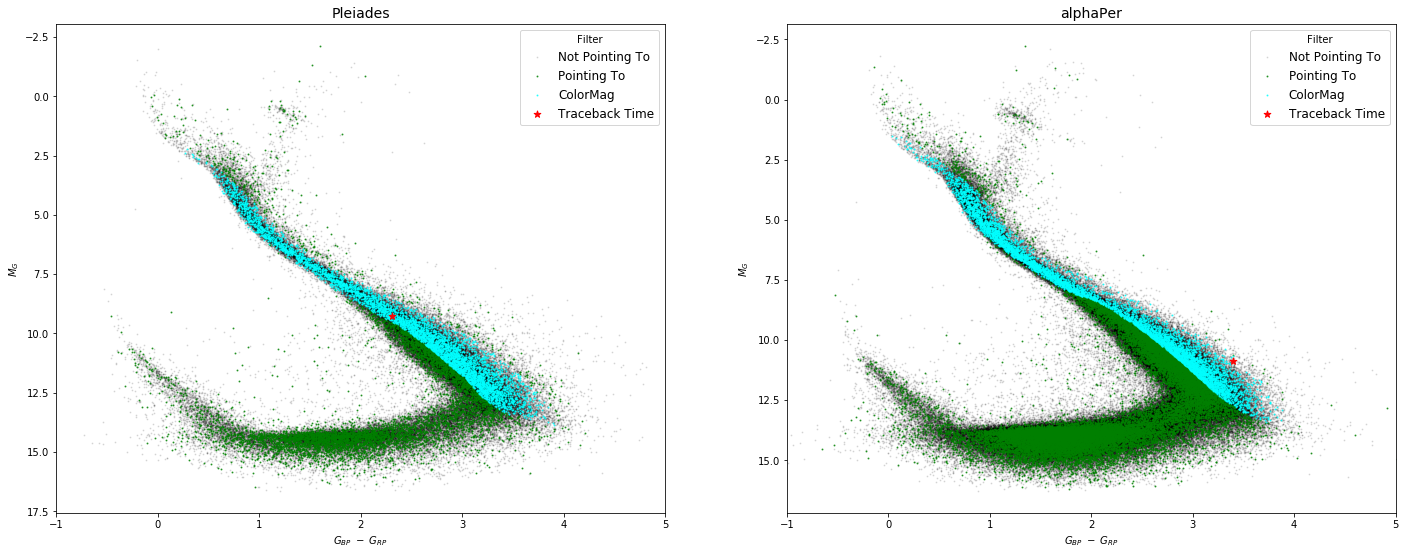

In [21]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('Score == 0').plot_hrdiagram(ax=ax[i], color='black', alpha=0.1, s=1, label="Not Pointing To")
    #cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members', alpha=0.5, s=1)
    search_results[cl].query('Score == 1').plot_hrdiagram(ax=ax[i], color='green', alpha=0.7, s=1, label="Pointing To")
    search_results[cl].query('Score == 2').plot_hrdiagram(ax=ax[i], color='cyan', alpha=0.7, s=1, label="ColorMag")
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=50,marker='*', label="Traceback Time")

    ax[i].set_title(cl, fontsize=14)
    ax[i].legend(fontsize=12, title='Filter')

In [22]:
filters = ['SearchResults','PointingTo','ColorModel','TracebackTime']
for i,f in enumerate(filters):
    n_Pleiades = len(search_results['Pleiades'].objs.query('Score >= @i'))
    n_alphaPer = len(search_results['alphaPer'].objs.query('Score >= @i'))
    print(f'Measure: {f}, Pleiades: {n_Pleiades}, alphaPer: {n_alphaPer}')

Measure: SearchResults, Pleiades: 107919, alphaPer: 291664
Measure: PointingTo, Pleiades: 11485, alphaPer: 29590
Measure: ColorModel, Pleiades: 4912, alphaPer: 5993
Measure: TracebackTime, Pleiades: 1, alphaPer: 1


Text(0.5, 1.0, 'alphaPer Known Members and Candidate')

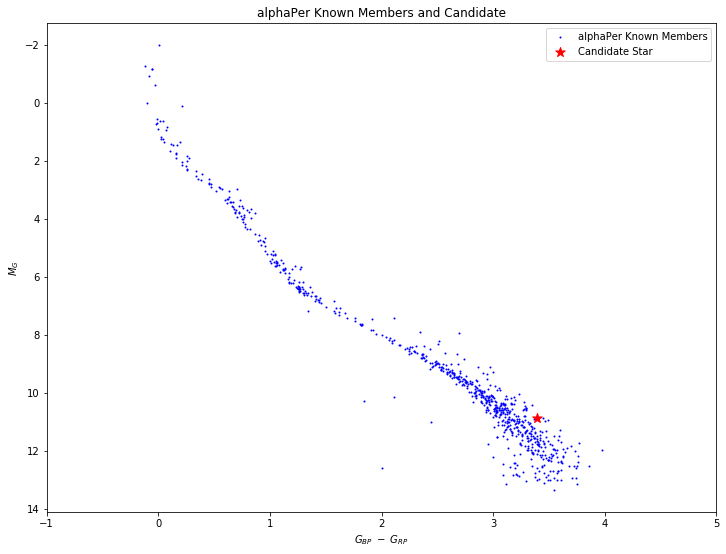

In [23]:
fig = plt.figure(figsize=(12,9))
ax = fig.subplots(1,1)

cl = 'alphaPer'
cluster_members[cl].plot_hrdiagram(ax=ax, color='blue', label=f'{cl} Known Members', alpha=1, s=1)
search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax, color='red', alpha=1, s=100,marker='*', label="Candidate Star")

ax.legend()
ax.set_title('alphaPer Known Members and Candidate')

In [24]:
cols = ['Inbounds','WithinDist','PointsTo','TraceBackTime','ColorMag','TBTok','Score']
search_results['Pleiades'].query('Score==3').objs[cols]

KeyError: "['Inbounds', 'TraceBackTime', 'WithinDist', 'PointsTo'] not in index"

In [21]:
search_results['alphaPer'].query('Score==3').objs[cols]

,Inbounds,WithinDist,PointsTo,TraceBackTime,ColorMag,TBTok,Score
source_id,,,,,,,
224510864123281920,True,True,True,8.221947e+07,True,True,3
286682611675295104,True,True,True,7.661404e+07,True,True,3
495118852019281280,True,True,True,7.086331e+07,True,True,3


In [22]:
#from locate_cluster_outliers.src.gaiastars import gaiastars as gs
from locate_cluster_outliers.src.plotting import make_square_axes, getTangentPoints, plot_points_to

In [23]:
maxsep = cluster_members['alphaPer'].maxsep() /2.0
points_to = search_results['alphaPer'].points_to(cluster_info.loc['alphaPer']['coords'],maxsep.value, inplace=False, allcalcs=True)

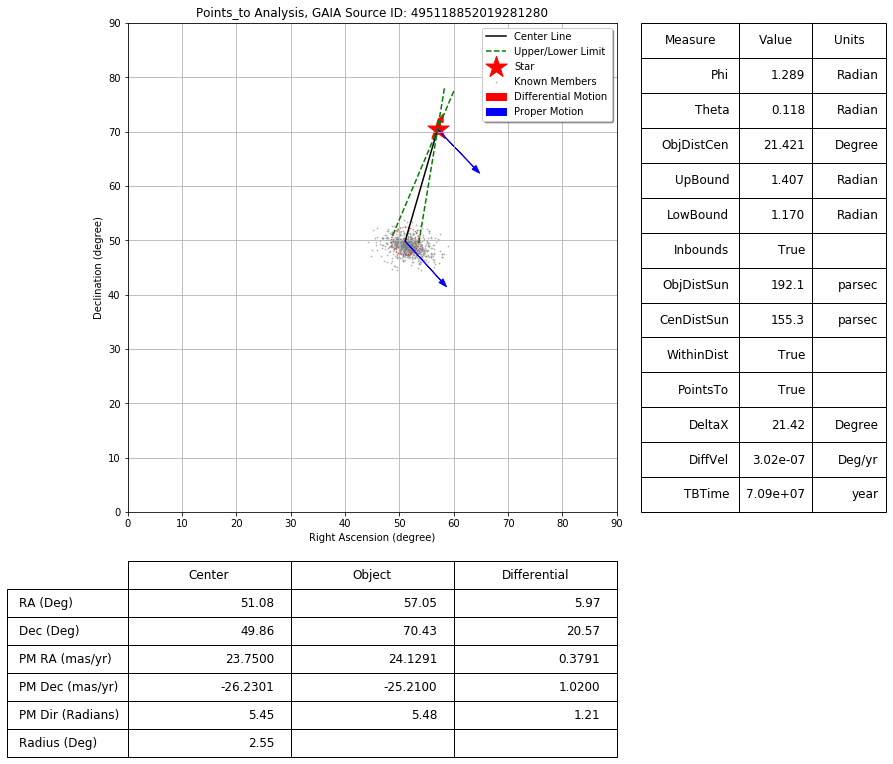

In [24]:
i =search_results['alphaPer'].query('Score==3').objs.index[2]

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()

plot_points_to(points_to.loc[i],cluster_members['alphaPer'], ax)
make_square_axes(ax)

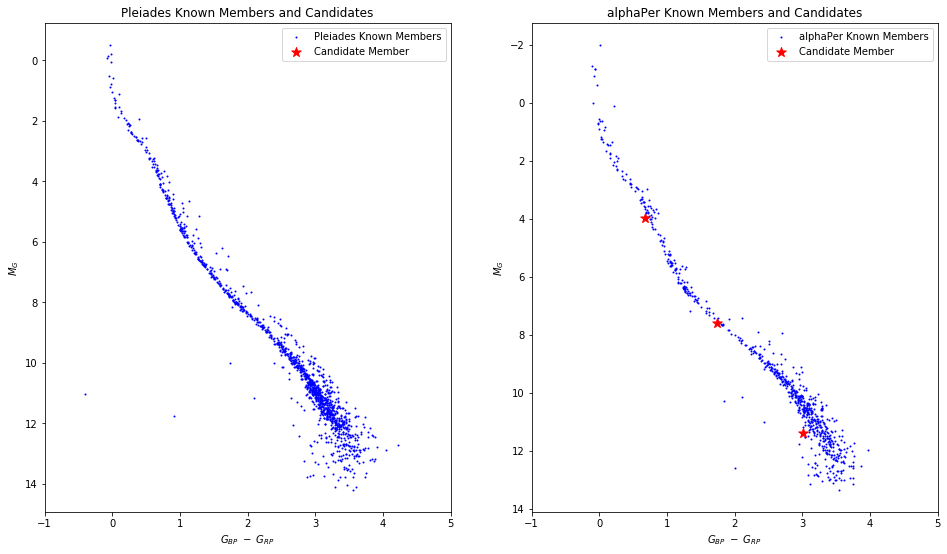

In [25]:
fig = plt.figure(figsize=(16,9))
axs = fig.subplots(1,2)

for ax,cl in zip(axs, cluster_names):
    cluster_members[cl].plot_hrdiagram(ax=ax, color='blue', label=f'{cl} Known Members', alpha=1, s=1)
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax, color='red', alpha=1, s=100,marker='*', label="Candidate Member")

    ax.legend()
    ax.set_title(f'{cl} Known Members and Candidates')

## Trajectory

In [26]:
def cartesian_to_spherical(xyz):
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical

In [27]:
def get_trajectory(coord, tval, default_rv= 5*u.km/u.second):
    c = coord.galactic
    xyz = c.cartesian.xyz.reshape(-1,1) # in pc
    
    pm_l_cosb = c.pm_l_cosb
    pm_b = c.pm_b
    
    d_xyz = c.velocity.d_xyz.to(u.pc/u.year).reshape(-1,1)
    
    xyz_t = xyz + d_xyz.dot(tval)
    
    spherical = cartesian_to_spherical(xyz_t.value)
    
    return spherical

In [28]:
tval = np.linspace(-120e6, 0, 10001).reshape(1,-1)*u.year

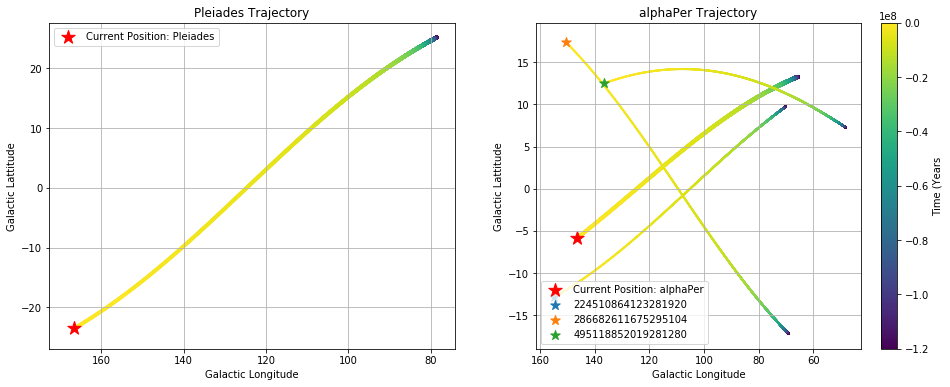

In [29]:
fig = plt.figure(figsize=(16,6))
axs = fig.subplots(1,2)

for cl,ax in zip(cluster_names, axs):
    c = cluster_info.loc[cl]['coords'].galactic
    sphere_t = get_trajectory(c, tval)
    
    pcm = ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=8, c=tval[0])
    ax.scatter(c.l, c.b,s=200,marker='*', color='red', label=f'Current Position: {cl}')
    
    #plot trajectories of candidates:
    candidates = search_results[cl].query('Score == 3')
    cand_coords = candidates.get_coords().galactic
    for i, c in enumerate(cand_coords):
        sphere_t = get_trajectory(c, tval)
        ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=1, c=tval[0])
                   
        ax.scatter(c.l, c.b,s=100,marker='*',label=list(candidates.objs.index)[i])
                   
    #ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
    #ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
    ax.set_title(f'{cl} Trajectory')
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Lattitude')
    ax.legend()
    ax.grid()
    ax.invert_xaxis()
fig.colorbar(pcm, label='Time (Years')

In [30]:
candidates.objs.TraceBackTime

source_id
224510864123281920    8.221947e+07
286682611675295104    7.661404e+07
495118852019281280    7.086331e+07
Name: TraceBackTime, dtype: float64

In [31]:
def pm_to_dxyz(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity):
    """
    computes d_xyz from ra, dec,d distance, pmra_cosdec and pm_dec, given a sample of radial velocity
    Arguemnts:
  
    """
    v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    v_dec = (pm_dec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #form the derivative matrix
    sin_alpha = np.sin(ra); cos_alpha = np.cos(ra)
    sin_delta = np.sin(dec); cos_delta=np.cos(dec)
    
    #shape should be 3x3
    dm = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             0,            cos_delta]).reshape(3,3)

    n = len(radial_velocity)
    eq_v = np.array([radial_velocity.value, np.full(n,v_ra.value), np.full(n, v_dec.value)]) *u.km/u.second
    d_xyz = dm.dot(eq_v)
    
    return d_xyz

In [32]:
def valid_rv(star, center, tt_min, rv_sample):
    """
    returns boolean vector indicating which members of rv_sample allow for a travel time from center to star greater than mintt
    """
    
    #get velocity column vectors for star for each element of rv_sample
    d_xyz_s = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv_sample)
    
    #center velocity column vector
    d_xyz_c = center.velocity.d_xyz.reshape(3,1)
    #velocity in center reference frame
    d_xyz_s_csr = d_xyz_s - d_xyz_c
    
    #space velocity and convert to pc/year
    vel_csr = np.sqrt((d_xyz_s_csr**2).sum(axis=0)).to(u.pc/u.year)
    
    #distance btwn center and star
    d=center.separation_3d(star) #comes back in pc
    
    #how long did it take given the sample of velocities
    tt_sample = d/vel_csr # should be in years
    
    rv_valid = tt_sample >= tt_min
    
    return rv_valid, tt_sample

In [43]:
def separation_t( star, center, rv, travel_time):
    """
    calculates separation of center and star at each of the (traveltime, rv) pair
    travel_time is signed quantity <0 => time in past; >0 => time in future
    """
    tt = travel_time.to(u.year).reshape(1,-1)
    
    cen_pos = center.cartesian.xyz.reshape(3,1)
    cen_d_xyz = center.velocity.d_xyz.reshape(3,1).to(u.pc/u.year)
    
    cen_delta_pos = cen_d_xyz.dot(tt)
    cen_pos_t = cen_pos + cen_delta_pos
    
    star_pos = star.cartesian.xyz.reshape(3,1)
    star_d_xyz = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv)
    tt_stack = np.vstack([tt]*3)
    star_delta_pos = star_d_xyz*tt_stack
    star_pos_t = star_pos+star_delta_pos
    
    #calculate the separations
    delta_xyz = star_pos_t - cen_pos_t
    seps = np.sqrt((delta_xyz**2).sum(axis=0))
    
    return seps

In [44]:
def traceback3d(star, center, tidal_r, rvsample):
    v_rv, tt_sample= valid_rv(star, center,  20e6*u.year, rvsample)
    
    seps = separation_t(star, center, rvsample, -1*tt_sample)
    
    valid_seps = seps <= tidal_r
    min_sep_i = seps.argmin()
    min_sep = seps[min_sep_i]
    min_sep_time = -1.0*tt_sample[min_sep_i]

    if np.any(valid_seps):
        rv_i = np.arange(len(rvsample))
        #get max travel time for seps <= tidal_r
        am = tt_sample[valid_seps].argmax()
        am_i = rv_i[valid_seps][am]
        rv = rvsample[am_i].value
        tt = tt_sample[am_i].value
    else:
        rv =  tt = np.nan
    
    return {'RequiredRadialVelocity': rv, 'ImpliedTravelTime': tt, 'MinSeparation':min_sep, 'MinSepTime':min_sep_time}

In [45]:
rv_sample3 = np.concatenate([np.linspace(-100, -20, 800, endpoint=False),
                        np.linspace(-20,20,1000, endpoint=False),
                        np.linspace(20, 100, 800)])*u.km/u.second

In [46]:
candidates = {}
tb_results = {}
for cl in cluster_names:
    candidates[cl] = search_results[cl].query('Score == 3')
    coords = candidates[cl].get_coords(recalc=True, default_rv=True)
    tb_results[cl] = pd.DataFrame([traceback3d(c, cluster_info.loc[cl]['coords'], 10*u.pc, rv_sample3) for c in coords],
                                 index = pd.Index(list(candidates[cl].objs.index), name =search_results[cl].objs.index.name ))


In [47]:
tb_results['Pleiades']

""
source_id


In [48]:
tb_results['alphaPer']

,RequiredRadialVelocity,ImpliedTravelTime,MinSeparation,MinSepTime
source_id,,,,
224510864123281920,NaN,NaN,33.36940133843656 pc,-437405.8283658682 yr
286682611675295104,NaN,NaN,11.181614205114482 pc,-4261078.354944157 yr
495118852019281280,NaN,NaN,62.41621138708242 pc,-652210.7820480003 yr


In [41]:
def plot_rv(ax,star, center, source_id, rvsample, ttsample, seps, tidal_radius=10*u.pc, xlim=None):
    #color boundaries
    vmin = 10e6; vmax=100e6


    current_sep = star.separation_3d(center)
    act_rv = star.radial_velocity.value

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

    ax.scatter(rvsample, ttsample, label=f'Source ID: {source_id}',
               c=ttsample, cmap='RdYlGn',  vmin=vmin, vmax=vmax, ls='-')
    ax.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='off' )    
    ax.set_ylabel('Travel Time to Current Separation (Years)')

    ax.set_title(f'Source ID: {source_id}')
    ax.legend()
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_xticklabels([])

    divider = make_axes_locatable(ax)
    ax1 = divider.append_axes("bottom", size="50%", pad=0.08)
    cax = divider.append_axes("right", size="5%", pad=0.08)


    pcm = ax1.scatter(rvsample, seps, c=tt_sample,cmap='RdYlGn',  vmin=vmin, vmax=vmax,
                      label='Modeled')
    ax1.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax1.axhline(current_sep.value, color='red', ls='--', label='Current Separation')
    ax1.axhline(tidal_radius.value, color='blue', ls='--', label='Tidal Radius')
    ax1.set_xlabel('Radial Velocity (km/s)')
    ax1.set_ylabel('Separation at Current Sep Travel Time (pc)')
    ax1.grid()
    ax1.legend()
    ax1.set_xlim(xlim)
    #zz=ax[1].set_title('Separation')
    cb = plt.colorbar( pcm, ax=ax1, cax=cax )
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    cb.ax.set_ylabel('Travel Time (Years)', rotation=-90)

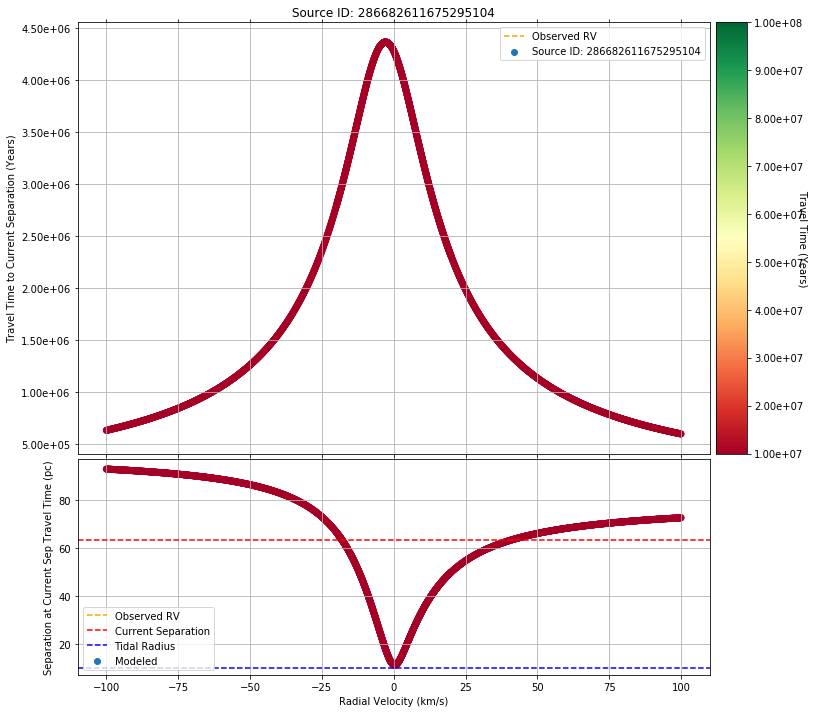

In [42]:
cl='alphaPer'
source_id = 286682611675295104

candidates[cl] = search_results[cl].query('Score == 3')
coords = candidates[cl].get_coords(recalc=True, default_rv=True)
star_i = candidates[cl].objs.index.get_loc(source_id)

v_rv, tt_sample= valid_rv(coords[star_i],cluster_info.loc[cl]['coords'],20e6*u.year,rv_sample3)
seps = separation_t(coords[star_i],cluster_info.loc[cl]['coords'],rv_sample3, -1*tt_sample)

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
plot_rv(ax,coords[star_i], cluster_info.loc[cl]['coords'], source_id, rv_sample3, tt_sample, seps, xlim=None)